<a href="https://colab.research.google.com/github/spirosChv/neuro208/blob/main/practicals/Practical_3c.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulating dendrites - Part 3: Integrating inputs with active dendritic conductances

In this notebook we will add ionic mechanisms in the dendrites! In this exercise we will see how inputs can be amplified by active sodium conductances.

In [1]:
!pip install neuron --quiet

     |████████████████████████████████| 14.9 MB 4.7 MB/s 


## Compile ion channel models (`.mod` files)

In [2]:
# @title Download the `.mod` file from github
# @markdown Execute this cell.
 
!rm -rf imbizo2022/
!rm -rf x86_64/
!git clone https://github.com/spirosChv/imbizo2022.git
!mv imbizo2022/mechanisms/traub.mod .
!nrnivmodl

Cloning into 'imbizo2022'...
remote: Enumerating objects: 276, done.
remote: Counting objects: 100% (92/92), done.
remote: Compressing objects: 100% (88/88), done.
remote: Total 276 (delta 53), reused 8 (delta 2), pack-reused 184
Receiving objects: 100% (276/276), 413.11 KiB | 11.80 MiB/s, done.
Resolving deltas: 100% (176/176), done.
/content
Mod files: "./traub.mod"

Creating 'x86_64' directory for .o files.

 -> Compiling mod_func.cpp
 -> NMODL ../traub.mod
Translating traub.mod into /content/x86_64/traub.c
Thread Safe
 -> Compiling traub.c
 => LINKING shared library ./libnrnmech.so
 => LINKING executable ./special LDFLAGS are:    -pthread
Successfully created x86_64/special


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from neuron import h
from neuron.units import mV, ms, um
h.load_file("stdrun.hoc")

1.0

In [4]:
# @title Make nicer plots -- Execute this cell
def mystyle():
  """
  Create custom plotting style.

  Returns
  -------
  my_style : dict
      Dictionary with matplotlib parameters.

  """
  # color pallette
  style = {
      # Use LaTeX to write all text
      "text.usetex": False,
      "font.family": "DejaVu Sans",
      "font.weight": "bold",
      # Use 16pt font in plots, to match 16pt font in document
      "axes.labelsize": 16,
      "axes.titlesize": 20,
      "font.size": 16,
      # Make the legend/label fonts a little smaller
      "legend.fontsize": 14,
      "xtick.labelsize": 14,
      "ytick.labelsize": 14,
      "axes.linewidth": 2.5,
      "lines.markersize": 10.0,
      "lines.linewidth": 2.5,
      "xtick.major.width": 2.2,
      "ytick.major.width": 2.2,
      "axes.labelweight": "bold",
      "axes.spines.right": False,
      "axes.spines.top": False
  }

  return style


plt.style.use("seaborn-colorblind")
plt.rcParams.update(mystyle())

In [5]:
# Simulation parameters
tstop = 100 * ms  # ms
h.dt = 0.1 * ms  # ms
vinit = -65 * mV  # initial membrane potential

## Define `h.Sections` and their passive/active properties

Create a soma and two dendrites (as in exercise1), define their anatomical and biophysical properties and connect them.

In [6]:
# Create a soma and two dendrites and connect them.
soma = h.Section(name='soma')
dend0, dend1 = [h.Section(name=n) for n in ['dend0', 'dend1']]

# Define properties of soma
soma.diam = 20  # diameter (um)
soma.L = 20  # length (um)
soma.Ra = 100  # Axial resistance (Ohm * cm)
soma.cm = 1  # specific membrane capacitance (uF/cm2)   
soma.nseg = 1  # number of segments

# Insert only passive conductance into soma (in contrast to previous two exercises)    
soma.insert('pas')
for seg in soma:
  seg.pas.e = -65  # Reversal potential (mV)
  seg.pas.g = 0.0003  # Leak conductance (S/cm2)

# Define properties of dend0
dend0.diam = 5 * um  # diameter (um)
dend0.L = 500 * um  # length (um)
dend0.cm = 1  # specific membrane capacitance (uF/cm2) 
dend0.Ra = 100  # Axial resistance (Ohm * cm)
dend0.nseg = 11  # number of segments

# Define properties of dend0
dend1.diam = 3 * um  # diameter (um)
dend1.L = 200 * um  # length (um)
dend1.cm = 1  # specific membrane capacitance (uF/cm2) 
dend1.Ra = 100  # Axial resistance (Ohm * cm)
dend1.nseg = 13  # number of segments

Let's add active mechanisms onto `dend1`.

In [7]:
print(h.traub.code)

COMMENT
All the channels are taken from same good old classic articles.
The arrengment was done after:
Kang, S., Kitano, K., and Fukai, T. (2004). 
  Self-organized two-state membrane potential 
  transitions in a network of realistically modeled 
  cortical neurons. Neural Netw 17, 307-312.

Whenever available I used the same parameters they used,
except in n gate:
  n' = phi*(ninf-n)/ntau

Kang used phi = 12
I used phi = 1

Written by Albert Gidon & Leora Menhaim (2004).
ENDCOMMENT

NEURON {
  SUFFIX traub
  NONSPECIFIC_CURRENT i
  RANGE il, iNa, iK
  RANGE el, eNa, eK
  RANGE gl, gnabar, gkbar
  RANGE v_shft
}

UNITS {
    (mA) = (milliamp)
    (mV) = (millivolt)
    (S) = (siemens)
}

PARAMETER {
    gnabar = .03 (S/cm2)    :Traub et. al. 1991
    gkbar = .015 (S/cm2)    :Traub et. al. 1991
    gl = 0.00014 (S/cm2) :Siu Kang - by email.
    el = -62.0 (mV) :Siu Kang - by email.
    eK = -80 (mV)   :Siu Kang - by email.
    eNa = 90 (mV)   :Leora
    v_shft = 49.2 (mV) : shift to ap

**Mathematical derivation of `vtrap(x, y)` function**

Some rate coefficient obey in the general equation:

\begin{equation}
\alpha = \frac{x}{\text{exp}(x/y) - 1}
\end{equation}

But, when $|x/y| \approx 0$ then the denominator becomes close to zero and the the rate coefficient goes to infinity. To avoid this, we use the [Taylor expansion](https://en.wikipedia.org/wiki/Taylor_series) in order to approximate the value of the rate coefficient at this point.

Any real or complex function $f$ can be approximated by an infinite series:

\begin{equation}
f(x) = \sum_{n=0}^{\infty}\frac{f^{(n)}(\alpha)}{n!}(x-\alpha)^n
\end{equation}

where $f^{(n)}(\alpha)$ denotes the n-th derivative of $f$ at point $\alpha$. When $\alpha=0$ the series called also a [Maclaurin series](https://en.wikipedia.org/wiki/Colin_Maclaurin#Contributions_to_mathematics).

If $f(x)=e^x$ and $\alpha=0$, then $f^{(n)}(x)=f(x)$

\begin{equation}
f(x) = \sum_{n=0}^{\infty}\frac{f^{(n)}(\alpha)}{n!}(x-\alpha)^n = \sum_{n=0}^{\infty}\frac{x^n}{n!} = 1 + x + \frac{x^2}{2} + \frac{x^3}{6} + \dots
\end{equation}

Using only the 3 first terms, and setting $f(x/y)=\text{exp}(x/y) - 1$:

\begin{align}
\alpha &= \frac{x}{\text{exp}(x/y) - 1} \\
&= \frac{x}{\sum_{n=0}^{\infty}\frac{(x/y)^n}{n!} - 1} \\
&\approx \frac{x}{1 + (x/y) + (x/y)^2/2 - 1} \\
&= \frac{x}{(x/y) + (x/y)^2/2} \\
&= \frac{1}{(1/y) + x(1/y)^2/2} \\
&= \frac{y}{1 + (x/y)/2} \\
&= \frac{y}{1 + x/2y} \\
\end{align}

For any $|\epsilon| \ll 1$ then $1/(1+\epsilon)$ is very well approximated by $1/(1-\epsilon)$.

Thus, when $|x/y| \ll 1$, then:

\begin{equation}
\alpha = \frac{y}{\text{exp}(x/y) - 1} \approx \frac{y}{1 - x/2y} 
\end{equation}

Following the same steps, we can avoid zeros in the denominators of rate equations.

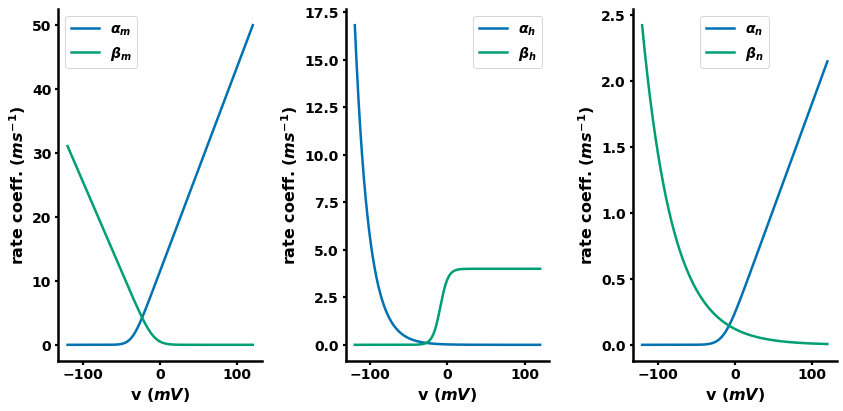

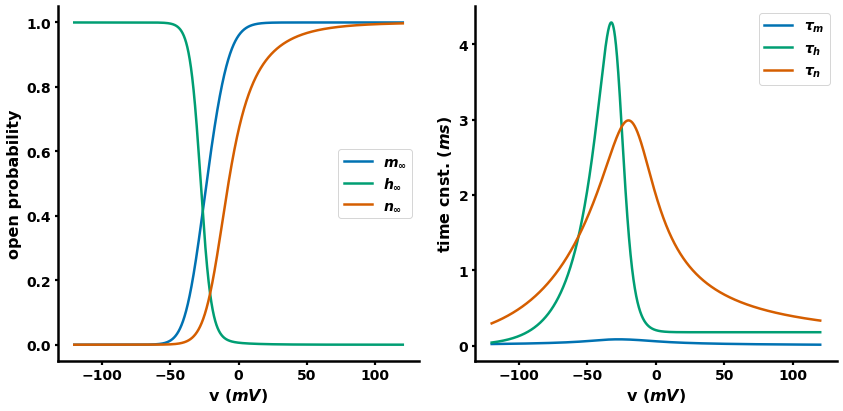

In [8]:
# @markdown Plot the gating variables
def Exp(x):
  return np.where(x < -100, 0, np.exp(x))


def vtrap(x=0, y=0):
  return np.where(np.abs(x/y) < 1e-6, y*(1 - x/y/2), x/(Exp(x/y) - 1))


def inf_tau(a, b, qt=1):
  """
  Calculate the steady-state and the time constant.

  Args:
    a : list
      List with alpha values
    b : list
      List with beta values
    qt : float, optional
      Temperature correction. Default is 1.
  
  ----
  
  Returns:
    xinf : float
      The gate variable steady-state.
    xtau: float
      The gate variable time constant in ms.
  """

  a = np.array(a)
  b = np.array(b)

  xinf = a/(a+b)
  xtau = 1/(a+b)
  return xinf, xtau/qt


qt = 3**((35 - 32)/10)

v = np.linspace(-120, 120, 10000)

alpha_m, beta_m = [], []
alpha_h, beta_h = [], []
alpha_n, beta_n = [], []

vt = v + 49.2
alpha_m = 0.32*vtrap(-(vt - 13.1), 4)
beta_m = 0.28*vtrap((vt - 40.1), 5)

alpha_h = 0.128*np.exp(-(vt - 17)/18)
beta_h = 4/(1 + np.exp(-(vt - 40)/5))

alpha_n = 0.016*vtrap(-(vt - 35.1), 5)
beta_n = 0.25*np.exp(-(vt - 20)/40)



plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.plot(v, alpha_m, label=r'$\alpha_m$')
plt.plot(v, beta_m, label=r'$\beta_m$')
plt.xlabel(r'v ($mV$)')
plt.ylabel(r'rate coeff. ($ms^{-1}$)')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(v, alpha_h, label=r'$\alpha_h$')
plt.plot(v, beta_h, label=r'$\beta_h$')
plt.xlabel(r'v ($mV$)')
plt.ylabel(r'rate coeff. ($ms^{-1}$)')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(v, alpha_n, label=r'$\alpha_n$')
plt.plot(v, beta_n, label=r'$\beta_n$')
plt.xlabel(r'v ($mV$)')
plt.ylabel(r'rate coeff. ($ms^{-1}$)')
plt.legend()

plt.tight_layout()
plt.show()


minf, mtau = inf_tau(alpha_m, beta_m, qt)
hinf, htau = inf_tau(alpha_h, beta_h, qt)
ninf, ntau = inf_tau(alpha_n, beta_n, qt)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(v, minf, label=r'$m_\infty$')
plt.plot(v, hinf, label=r'$h_\infty$')
plt.plot(v, ninf, label=r'$n_\infty$')
plt.xlabel(r'v ($mV$)')
plt.ylabel('open probability')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(v, mtau, label=r'$\tau_m$')
plt.plot(v, htau, label=r'$\tau_h$')
plt.plot(v, ntau, label=r'$\tau_n$')
plt.xlabel(r'v ($mV$)')
plt.ylabel(r'time cnst. ($ms$)')
plt.legend()

plt.tight_layout()
plt.show()

In [9]:
# dend1 will have active conductances!
# Traub.mod contains HH-like Na and K conductances, as well as leak.
dend1.insert('traub')
for seg in dend1:
  seg.traub.gnabar = 0.1  # Sodium conductance (S/cm2)
  seg.traub.gkbar = 0.045  # Potassium conductance (S/cm2)
  seg.traub.gl = 0.0003  # Leak conductance (S/cm2)
  seg.traub.el = -65.  # Reversal potential for leak (mV)
  seg.traub.eK = -70.  # Reversal potential for potassium (mV)
  seg.traub.eNa = 90.  # Reversal potential for sodium in (mV)
  seg.traub.v_shft = 52.4  # Shifts the activation curve for sodium

Now, let's connect the compartments.

In [10]:
# Connect the `0` point of `dend0` to the `0` point of the soma, i.e., soma(0)
dend0.connect(soma(0), 0)
# Connect the `1` point of `dend0`, i.e., dend0(1), to the `0` point of the dend1, i.e., dend1(0)
dend1.connect(dend0(1), 0)

dend1

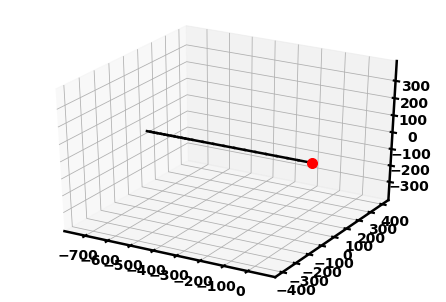

In [11]:
ps = h.PlotShape(True)  # False tells h.PlotShape not to use NEURON's gui
ps.plot(plt).mark(soma(0.5))
plt.show()

## Synaptic Stimulation

In [12]:
syn = h.ExpSyn(dend1(0.5)) # Place the synapse to the middle (0.5) of the soma
syn.e = 0  # Reverse potential of the synapse (mV)

# Create an artificial spike using h.NetStim() (an "event" to be delivered to the synapse)...
tsignal = 50
ns = h.NetStim(0.5)
ns.start = tsignal  # time when the spike arrives (in msec)     
ns.number = 1  # number of spikes (just one)

# ... and connect the event to the synapse.
# function arguments: NetCon(source, target, [threshold, delay, weight])
nc = h.NetCon(ns, syn)
nc.delay = 0  # synaptic delay (ms)
nc.weight[0] = 0.008*10  # synaptic weight (i.e., strength of the synapse)

## Example simulation

### Task 1: Compare the depolarization at the soma with and without active conductances in the dendrites

Let's first create our recording variables.

In [13]:
# record the necessary variables
vsoma_vec = h.Vector().record(soma(0.5)._ref_v)  # Membrane potential vector
vdend1_vec = h.Vector().record(dend1(0.5)._ref_v)  # Membrane potential vector
vdend0_vec = h.Vector().record(dend0(0.5)._ref_v)  # Membrane potential vector
iNa_vec = h.Vector().record(dend1(0.5).traub._ref_iNa)  # Sodium current vector
t_vec = h.Vector().record(h._ref_t)  # Time stamp vector

#### Step 1: Run the simulation with active conductances

In [14]:
# We add the channels here in case we re-run
for seg in dend1:
  seg.traub.gnabar = 0.1  # Sodium conductance (S/cm2)
  seg.traub.gkbar = 0.045  # Potassium conductance (S/cm2)

# reinitialize the simulator and run again
h.finitialize(vinit)
h.continuerun(tstop)

# Remove the first 20 msec of the plot (to make it look nice)
tremove = 20
vsoma_vec.remove(0, int(tremove/h.dt))
vdend0_vec.remove(0, int(tremove/h.dt))
vdend1_vec.remove(0, int(tremove/h.dt))
iNa_vec.remove(0, int(tremove/h.dt))
t_vec.remove(0, int(tremove/h.dt))

print(f'Active case: somatic depolarization is {round(vsoma_vec.max()-vsoma_vec[int((tsignal-tremove)/h.dt)-1], 2)} mV')
print(f'Active case: distal dendritic depolarization is {round(vdend1_vec.max()-vdend1_vec[int((tsignal-tremove)/h.dt)-1], 2)} mV')

# Save the results in a dictionary
results_active = {}
results_active['vsoma'] = np.array(vsoma_vec)
results_active['vdend0'] = np.array(vdend0_vec)
results_active['vdend1'] = np.array(vdend1_vec)
results_active['iNadend'] = np.array(iNa_vec)
results_active['time'] = np.array(t_vec)

Active case: somatic depolarization is 5.07 mV
Active case: distal dendritic depolarization is 21.89 mV


#### Step 2: Run the simulation without active conductances

In [15]:
# remove active conductances
for seg in dend1:
  seg.traub.gnabar = 0.0  # Sodium conductance in S/cm2
  seg.traub.gkbar = 0.0  # Potassium conductance in S/cm2
    
# reinitialize the simulator and run again
h.finitialize(vinit)
h.continuerun(tstop)

# Remove the first 20 msec of the plot (to make it look nice)
tremove = 20
vsoma_vec.remove(0, int(tremove/h.dt))
vdend0_vec.remove(0, int(tremove/h.dt))
vdend1_vec.remove(0, int(tremove/h.dt))
iNa_vec.remove(0, int(tremove/h.dt))
t_vec.remove(0, int(tremove/h.dt))

print(f'\nPassive case: somatic depolarization is {round(vsoma_vec.max()-vsoma_vec[int((tsignal-tremove)/h.dt)-1], 2)} mV')
print(f'Passive case: distal dendritic depolarization is {round(vdend1_vec.max()-vdend1_vec[int((tsignal-tremove)/h.dt)-1], 2)} mV')

# Save the results in a dictionary
results_passive = {}
results_passive['vsoma'] = np.array(vsoma_vec)
results_passive['vdend0'] = np.array(vdend0_vec)
results_passive['vdend1'] = np.array(vdend1_vec)
results_passive['iNadend'] = np.array(iNa_vec)
results_passive['time'] = np.array(t_vec)


Passive case: somatic depolarization is 3.97 mV
Passive case: distal dendritic depolarization is 21.89 mV


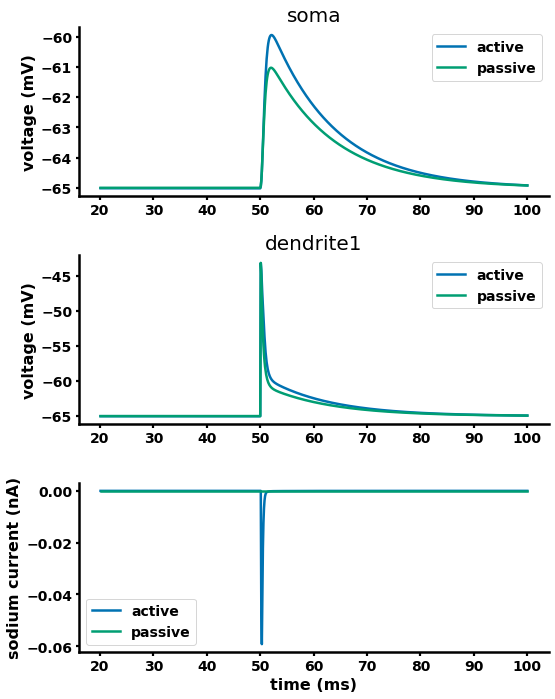

In [16]:
# Plot the results
plt.figure(figsize=(8, 10))
plt.subplot(3, 1, 1)
plt.plot(results_active['time'], results_active['vsoma'], label='active')
plt.plot(results_passive['time'], results_passive['vsoma'], label='passive')
plt.ylabel('voltage (mV)')
plt.title('soma')
plt.legend()
plt.subplot(3, 1, 2)
plt.plot(results_active['time'], results_active['vdend1'], label='active')
plt.plot(results_passive['time'], results_passive['vdend1'], label='passive')
plt.ylabel('voltage (mV)')
plt.title('dendrite1')
plt.legend()
plt.subplot(3, 1, 3)
plt.plot(results_active['time'], results_active['iNadend'], label='active')
plt.plot(results_passive['time'], results_passive['iNadend'], label='passive')
plt.ylabel('sodium current (nA)')
plt.xlabel('time (ms)')
plt.legend()
plt.tight_layout()
plt.show()

### Task 2: Insert 1 to 5 synapses like this one in the same location. In this case, this is equivalent to increasing the weight 1 to 5 times.

- What is the expected (arithmetic sum) versus actual (simulated output)?
- Is their relationship linear or non-linear?
- How many synapses are needed to elicit a dendritic spike?

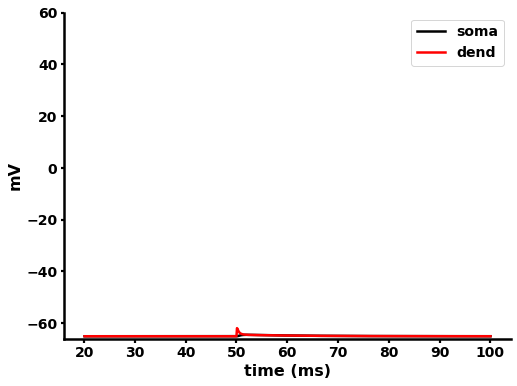


Somatic depolarization is 0.55 mV
Distal Dendritic depolarization is 3.14 mV


In [17]:
nsyn = 1 # @param {type:"slider", min:1, max:25, step:1}
nc.weight[0] = 0.008*nsyn  # set the weight

# add the active conductance back to dend1
for seg in dend1:
  seg.traub.gnabar = 0.1  # Sodium conductance (S/cm2)
  seg.traub.gkbar = 0.045  # Potassium conductance (S/cm2)

# Run the simulation
h.finitialize(vinit)
h.continuerun(tstop)

# Remove the first 20ms to avoid artifacts
tremove = 20
vsoma_vec.remove(0, int(tremove/h.dt))
vdend1_vec.remove(0, int(tremove/h.dt))
t_vec.remove(0, int(tremove/h.dt))

plt.figure(figsize=(8, 6))
plt.plot(t_vec, vsoma_vec, color='black', label='soma')
plt.plot(t_vec, vdend1_vec, color='red', label='dend')
plt.xlabel('time (ms)')
plt.ylabel('mV')
plt.ylim([-66, 60])
plt.legend()
plt.show()

print (f'\nSomatic depolarization is {np.round(vsoma_vec.max()-vsoma_vec[int((tsignal-tremove)/h.dt)-1], 2)} mV')
print (f'Distal Dendritic depolarization is {np.round(vdend1_vec.max()-vdend1_vec[int((tsignal-tremove)/h.dt)-1], 2)} mV')

Now, let's run the loop!

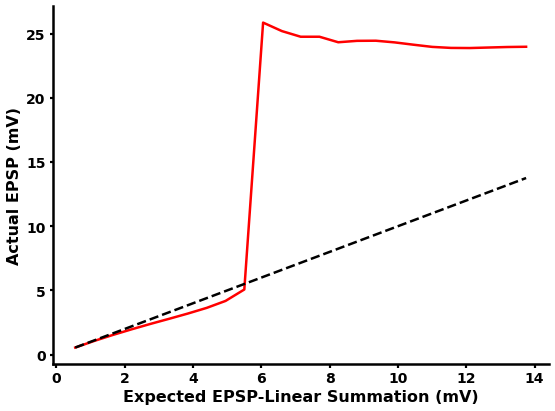

In [18]:
maxN = 25
actual_epsp = []
for i in range(maxN):
  nc.weight[0] = 0.008*(i+1)

  # reinitialize the simulator and run again
  h.finitialize(vinit)
  h.continuerun(tstop)
  
  # Remove the first 20 msec of the plot (to make it look nice)
  tremove = 20
  vsoma_vec.remove(0, int(tremove/h.dt))
  vdend1_vec.remove(0, int(tremove/h.dt))
  t_vec.remove(0, int(tremove/h.dt))
  actual_epsp.append(round(vsoma_vec.max() - vsoma_vec[int((tsignal-tremove)/h.dt)-1], 2))

# Calculate the expected EPSP
expected_epsp = [actual_epsp[0]*i for i in range(1, maxN+1)]

plt.figure(figsize=(8, 6)) 
plt.plot(expected_epsp, actual_epsp, color='red')
plt.plot(expected_epsp, expected_epsp, linestyle='dashed', color='black')
plt.xlabel('Expected EPSP-Linear Summation (mV)')
plt.ylabel('Actual EPSP (mV)')
plt.tight_layout()
plt.show()

The integration is linear and then slightly sublinear, but when the threshold for sodium channels opening is crossed, we observe a massive response. Congratulations, you have simulated your first active dendrite!